<!-- ![image.png](attachment:image.png) -->

# Netflix 추천 시스템 
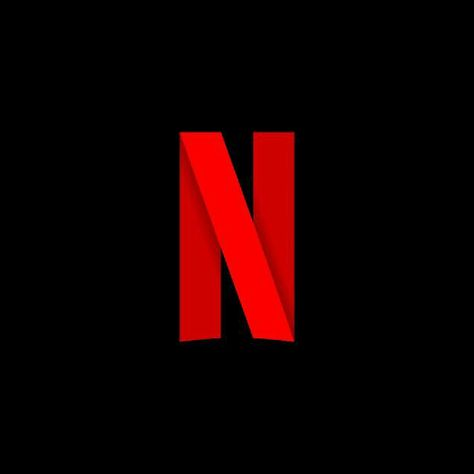

# 🔧 데이터 처리

### 0. 데이터 명세

- 데이터
    - Movie ID (as first line of each new movie record / file)
    - Customer ID
    - Rating (1 to 5)
    - Date they gave the ratings
- 무비 메타 데이터

### 1. 데이터 로드

In [25]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
# 원본 데이터 형태 

df0 = pd.read_csv("./Data/Netflix_Prize/combined_data_1.txt")
df0.head()

,,1:
1488844,3.0,2005-09-06
822109,5.0,2005-05-13
885013,4.0,2005-10-19
30878,4.0,2005-12-26
823519,3.0,2004-05-03


In [36]:
# 날짜 컬럼 제거 

df1 = pd.read_csv("./Data/Netflix_Prize/combined_data_1.txt",
                  header=None, names=['Cust_Id', 'Rating'],
                  usecols = [0,1])

df1['Rating'] = df1['Rating'].astype(float)
                  
print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset 1 examples-')
print(df1.iloc[::5000000, :])

Dataset 1 shape: (24058263, 2)
-Dataset 1 examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


In [9]:
# 나머지 데이터도 모두 로드 (+ 날짜 컬럼 제거 적용)

# df2 = pd.read_csv("./Data/Netflix_Prize/combined_data_2.txt",
#                   header=None, names=['Cust_Id', 'Rating'],
#                   usecols = [0,1])
# df3 = pd.read_csv("./Data/Netflix_Prize/combined_data_3.txt",
#                   header=None, names=['Cust_Id', 'Rating'],
#                   usecols = [0,1])
# df4 = pd.read_csv("./Data/Netflix_Prize/combined_data_4.txt",
#                   header=None, names=['Cust_Id', 'Rating'],
#                   usecols = [0,1])

# df2['Rating'] = df2['Rating'].astype(float)
# df3['Rating'] = df3['Rating'].astype(float)
# df4['Rating'] = df4['Rating'].astype(float)

# print('Dataset 2 shape: {}'.format(df2.shape))
# print('Dataset 3 shape: {}'.format(df3.shape))
# print('Dataset 4 shape: {}'.format(df4.shape))

Dataset 2 shape: (26982302, 2)
Dataset 3 shape: (22605786, 2)
Dataset 4 shape: (26851926, 2)


In [37]:
# 데이터 합치기

df = df1

# load less data
# df = pd.concat([df1, df2, df3, df4], ignore_index=True)

print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])

Full dataset shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


### 2. 데이터 확인

In [38]:
# 평점 count

p = df.groupby('Rating')['Rating'].agg(['count'])
p

,count
Rating,
1.0,1118186
2.0,2439073
3.0,6904181
4.0,8085741
5.0,5506583


In [39]:
# 영화 count
# 'Rating'이 NaN인 컬럼, 즉 영화 개수

movie_count = df.isnull().sum()[1]
print('영화 개수: ', movie_count)

# 아마도 데이터에서 평점이 없는 경우('Rating'이 NaN인)는 영화 정보만 담긴
# 첫 번째 줄일 가능성이 있다?

영화 개수:  4499


In [40]:
# 사용자 count
# 고유 사용자 수에서 영화 개수를 뺀 값 (실제 사용자 수)

cust_count = df['Cust_Id'].nunique() - movie_count
print('사용자 수: ', cust_count)

사용자 수:  470758


In [41]:
# 평점 count
# 전체 데이터에서 영화 개수를 뺀 값 (실제 평점 개수)

rating_count = df['Cust_Id'].count() - movie_count
print('평점 수: ', rating_count)

평점 수:  24053764


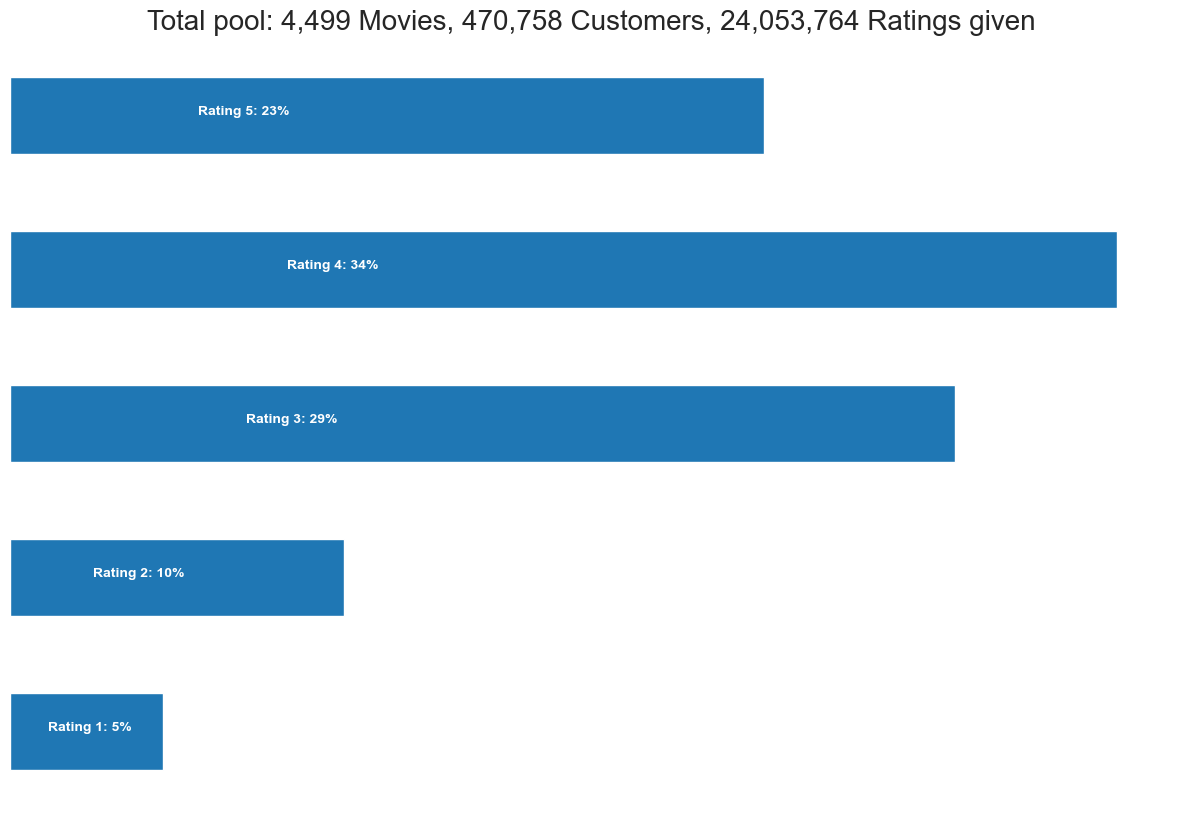

In [42]:
# 시각화

ax = p.plot(kind='barh', legend=False, figsize=(15,10))
plt.title('Total pool: {:,} Movies, {:,} Customers, {:,} Ratings given'
         .format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1,
            'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]),
           color='white', weight='bold')

### 3. 데이터 전처리 

Movie Id 컬럼 추가
- 반복문으로 순회하며 Movie Id열을 추가하려고 하면 메모리 부족으로 Kernel이 중단됨
- 적절한 길이를 가진 NumPy 배열을 먼저 생성한 다음, 그 배열을 전체 열로 데이터프레임에 추가

In [43]:
# 기존의 영화 row(결측치)를 바탕으로 df_nan 생성
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

# Movie Id 값을 담을 NumPy 배열 생성
movie_np = []
movie_id = 1 # 첫 번째 영화의 Id를 1로 설정

# 결측치 구간에 movie id 할당
# i, j = 결측치가 있는 구간
# 그 구간에 동일한 movie id를 부여하고, 다음 구간에는 movie id 1을 증가해서 부여 
for i, j in zip(df_nan['index'][1:], df_nan['index'][:-1]):
    temp = np.full((1, i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# 마지막 결측치 이후에 남아 있는 데이터는 movie id가 계속 증가해서 부여
last_record = np.full((1, len(df) - df_nan.iloc[-1, 0] - 1), movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [44]:
# 기존의 영화 row 제거 ('Rating'이 null인)
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])

-Dataset examples-
          Cust_Id  Rating  Movie_Id
1         1488844     3.0         1
5000996    501954     2.0       996
10001962   404654     5.0      1962
15002876   886608     2.0      2876
20003825  1193835     2.0      3825


### 4. 데이터 슬라이싱

데이터 품질을 위해 불필요한 데이터 제거 
- 평점 수가 너무 적은 영화 제거 (인기 없는 영화 제거)
- 평점을 너무 적게 남긴 고객 제거 (활동이 적은 고객 제거)

In [45]:
f = ['count', 'mean']


### 평점 수가 너무 적은 영화 제거 ###
# 영화별 평점 수(count), 평균(mean) 통계
df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
# 제거 기준 설정 (평점 개수의 70% 분위수보다 적은 영화)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7), 0)
# 제거할 데이터들 변수에 저장 
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))


### 평점을 너무 적게 남긴 고객 제거 ###
df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 1799.0
Customer minimum times of review: 52.0


In [46]:
# 제거 및 데이터 shape 확인

print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])

Original Shape: (24053764, 3)
After Trim Shape: (17337458, 3)
-Data Examples-
          Cust_Id  Rating  Movie_Id
696        712664     5.0         3
6932490   1299309     5.0      1384
13860273   400155     3.0      2660
20766530   466962     4.0      3923


### 5. 사용자-영화 평점 매트릭스 생성

In [47]:
# pivot table 사용

df_p = pd.pivot_table(df, values='Rating', index='Cust_Id',
                     columns='Movie_Id')

print(df_p.shape)
df_p.head()

(143458, 1350)


Movie_Id,3,8,16,17,18,26,28,30,32,33,...,4472,4474,4478,4479,4485,4488,4490,4492,4493,4496
Cust_Id,,,,,,,,,,,,,,,,,,,,,
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,5.0,NaN,NaN,NaN,NaN,4.0,5.0,NaN,NaN,...,3.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 희소 행렬 사용

#Cust_Id_u = list(sorted(df['Cust_Id'].unique()))
#Movie_Id_u = list(sorted(df['Movie_Id'].unique()))
#data = df['Rating'].tolist()
#row = df['Cust_Id'].astype('category', categories=Cust_Id_u).cat.codes
#col = df['Movie_Id'].astype('category', categories=Movie_Id_u).cat.codes
#sparse_matrix = csr_matrix((data, (row, col)), shape=(len(Cust_Id_u), len(Movie_Id_u)))
#df_p = pd.DataFrame(sparse_matrix.todense(), index=Cust_Id_u, columns=Movie_Id_u)
#df_p = df_p.replace(0, np.NaN)

### 6. 영화 메타 데이터 로드

In [60]:
df_title = pd.read_csv("./Data/Netflix_Prize/movie_titles.csv",
                      encoding = "ISO-8859-1", header = None,
                      names = ['Movie_Id', 'Year', 'Name'],
                      on_bad_lines='skip')
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


# 🕊️ 추천 시스템 

## 협업 필터링 (Collaborative Filtering)

In [62]:
reader = Reader()

# 상위 100k 행만 사용해보기
# data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:], reader)
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']].head(100000), reader)


# SVD 행렬 분해 
# 세 개의 행렬로 분해:
    # U (사용자 행렬): 각 사용자의 선호도를 나타내는 행렬
    # Σ (특징 행렬): 각 특징(예: 영화 장르, 감독 등)의 중요도를 나타내는 대각 행렬
    # V (아이템 행렬): 각 아이템의 특징을 나타내는 행렬
# 예측: SVD는 이 세 개의 행렬을 곱하여 원래의 평점 행렬을 근사합니다. 
# 빈 값에 대해서는 예측된 값을 제공합니다. 
# 즉, 사용자가 아직 평가하지 않은 아이템에 대해 예측된 평점을 통해 추천을 생성합니다.
svd = SVD()

# 교차 검증 
cross_validate(svd, data, measures=['RMSE', 'MAE'])

{'test_rmse': array([0.99750822, 0.99551811, 0.99046564, 1.00651572, 0.99619737]),
 'test_mae': array([0.80108878, 0.80130552, 0.79796796, 0.8144366 , 0.80693106]),
 'fit_time': (0.6709840297698975,
  0.8214490413665771,
  0.7492330074310303,
  0.6999478340148926,
  0.6486551761627197),
 'test_time': (0.05052495002746582,
  0.05084085464477539,
  3.2700090408325195,
  0.05984020233154297,
  0.05868101119995117)}

#### 활용 예시

- user 783514 가 과거 평점 5점을 주었던 영화 리스트

In [64]:
df_785314 = df[(df['Cust_Id'] == 785314) & (df['Rating'] == 5)]
df_785314 = df_785314.set_index('Movie_Id')
df_785314 = df_785314.join(df_title)['Name']
print(df_785314)

Movie_Id
57                                            Richard III
175                                        Reservoir Dogs
311                                               Ed Wood
329                                                 Dogma
331                                           Chasing Amy
395                                         Captain Blood
788                                                Clerks
798                                                  Jaws
907                                       Animal Crackers
985                                             The Mummy
1552                                          Black Adder
1905    Pirates of the Caribbean: The Curse of the Bla...
2000                          Four Weddings and a Funeral
2122                                 Being John Malkovich
2342                                        Super Size Me
2360                                  Singin' in the Rain
2430                           Alien: Collector's Edition
2443 

- user 783514 에게 영화 추천해주기

In [66]:
user_785314 = df_title.copy()
user_785314 = user_785314.reset_index()
user_785314 = user_785314[~user_785314['Movie_Id'].isin(drop_movie_list)]

data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset()
svd.fit(trainset)

user_785314['Estimated_Score'] = user_785314['Movie_Id'].apply(lambda x: svd.predict(785314, x).est)

user_785314 = user_785314.drop('Movie_Id', axis=1)

user_785314 = user_785314.sort_values('Estimated_Score', ascending=False)

print(user_785314.head(10))

        Year                                        Name  Estimated_Score
2281  2003.0  The Looney Tunes Golden Collection: Vol. 1         5.000000
3455  2000.0                          Coupling: Season 1         5.000000
1252  1988.0                         Red Dwarf: Series 3         4.997392
2157  2004.0  The Looney Tunes Golden Collection: Vol. 2         4.971628
1765  2002.0                 An Evening With Kevin Smith         4.923322
4309  1993.0                            Army of Darkness         4.900823
2990  1990.0           The Simpsons: Treehouse of Horror         4.885392
4038  1999.0                     The Simpsons: Bart Wars         4.856210
3109  1987.0                   Evil Dead 2: Dead by Dawn         4.851199
2078  2002.0                                     Firefly         4.818605


## 피어슨 상관 계수 (Pearsons' R correlations)

- 피어슨 상관 계수(Pearson's R)를 사용하여 모든 영화 쌍의 평점 간의 선형 상관 관계를 측정한 후, 가장 높은 상관 관계를 가진 상위 10개의 영화를 제공

In [74]:
# def recommend(movie_title, min_count)
# movie_title = 추천을 원하는 영화의 제목
# min_count = 추천된 영화가 최소한 가져야 하는 평점 수 

def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons' R correlation - ")
    # 영화 Id 찾기
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    # 타겟 영화의 평점 벡터 선택
    target = df_p[i]
    # 피어슨 상관 계수 계산
    similar_to_target = df_p.corrwith(target)
    # 피어슨 상관 계수 데이터프레임 생성
    corr_target = pd.DataFrame(similar_to_target, columns=['Pearson R'])
    # 결측치를 제거한 후, 상관 계수가 높은 순서대로 정렬
    corr_target.dropna(inplace=True)
    corr_target = corr_target.sort_values('Pearson R', ascending=False)
    # 인덱스를 정수로 변환
    corr_target.index = corr_target.index.map(int)
    # 영화 제목과 평점 수, 평균 리뷰 점수 추가 
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['Pearson R', 'Name', 'count', 'mean']]
    # 추천된 영화 출력
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

In [75]:
recommend("X2: X-Men United", 0)

For movie (X2: X-Men United)
- Top 10 movies recommended based on Pearsons' R correlation - 
 Pearson R                                                  Name  count     mean
  1.000000                                      X2: X-Men United  98720 3.932202
  0.384550                              Batman Beyond: The Movie   2614 3.726855
  0.375967                                        Justice League   3591 3.710944
  0.361393                      Justice League: Justice on Trial   2961 3.718001
  0.338025                    Batman Beyond: Return of the Joker   3704 3.604752
  0.335256                                         Batman Begins  54922 4.236699
  0.328229                          Batman: Mask of the Phantasm   2823 3.767977
  0.327040 Batman: The Animated Series: Tales of the Dark Knight   2432 3.583059
  0.316666                       Dragon Ball Z: Super Android 13   2426 3.428689
  0.316166                              Mortal Kombat: The Movie   7633 3.165466
